In [29]:
import pickle
import warnings

import os, sys
WORKING_DIR = os.path.dirname(os.path.abspath(''))
sys.path.insert(1, os.path.join(WORKING_DIR,'LensQuEst'))

from universe import *
from halo_fit import *
from cmb import *
from flat_map import *
from weight import *
from pn_2d import *
import pickle
import seaborn as sns
from scipy.stats import spearmanr
import numpy as np
#######
IN_DATA_FNAMES = ['/oak/stanford/orgs/kipac/users/delon/LensQuEst/map_sims_%d.pkl'%(i) for i in range(1,51)]



warnings.filterwarnings("ignore")
#####
oup_fname = '../data/input/universe_Planck15/camb/CAMB_outputs.pkl'
print(oup_fname)
f = open(oup_fname, 'rb') 
powers,cl,c_lensed,c_lens_response = pickle.load(f)
f.close()

totCL=powers['total']
unlensedCL=powers['unlensed_scalar']

L = np.arange(unlensedCL.shape[0])
unlensedTT = unlensedCL[:,0]/(L*(L+1))*2*np.pi
F = unlensedTT
funlensedTT_log = interp1d(L, np.log(F), kind='linear', bounds_error=False, fill_value=0.)
funlensedTT = lambda L:np.exp(funlensedTT_log(L))


L = np.arange(cl.shape[0])
PP = cl[:,0]
rawPP = PP*2*np.pi/((L*(L+1))**2)
rawKK = L**4/4 * rawPP

fKK_log = interp1d(L, np.log(rawKK), kind='linear', bounds_error=False, fill_value=0.)
fKK = lambda L:np.exp(fKK_log(L))


L = np.arange(totCL.shape[0])

lensedTT = totCL[:,0]/(L*(L+1))*2*np.pi
F = lensedTT
flensedTT_log = interp1d(L, np.log(F), kind='linear', bounds_error=False, fill_value=0.)
flensedTT = lambda L:np.exp(flensedTT_log(L))


ftot = lambda l : flensedTT(l) + cmb.fForeground(l) + cmb.fdetectorNoise(l)


L = np.arange(c_lens_response.shape[0])

cTgradT = c_lens_response.T[0]/(L*(L+1))*2*np.pi

fTgradT_log = interp1d(L, np.log(cTgradT), kind='linear', bounds_error=False, fill_value=0.)
fTgradT = lambda L:np.exp(fTgradT_log(L))



print("Map properties")

# number of pixels for the flat map
nX = 1200
nY = 1200

# map dimensions in degrees
sizeX = 20.
sizeY = 20.

# basic map object
baseMap = FlatMap(nX=nX, nY=nY, sizeX=sizeX*np.pi/180., sizeY=sizeY*np.pi/180.)

# multipoles to include in the lensing reconstruction
lMin = 30.; lMax = 3.5e3

# ell bins for power spectra
lRange = (1., 2.*lMax)  # range for power spectra


# In[6]:


print("CMB experiment properties")

# Adjust the lMin and lMax to the assumptions of the analysis
# CMB S3 specs
cmb = StageIVCMB(beam=1.4, noise=7., lMin=lMin, lMaxT=lMax, lMaxP=lMax, atm=False)

# Total power spectrum, for the lens reconstruction
# basiscally gets what we theoretically expect the
# power spectrum will look like
forCtotal = lambda l: ftot(l) 

# # reinterpolate: gain factor 10 in speed
# L = np.logspace(np.log10(lMin/2.), np.log10(2.*lMax), 1001, 10.)
# F = np.array(list(map(forCtotal, L)))
# cmb.fCtotal = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)
cmb.fCtotal = ftot # no longer reinterpolating since it seems like it leads to errors?

from collections import defaultdict
in_data = defaultdict(list)

for fname in tqdm(IN_DATA_FNAMES):
    # Use 'with' for automatic file closing
    with open(fname, 'rb') as f:
        c_in_data = pickle.load(f)
        
    for key, value in c_in_data.items():
        # Convert to numpy array and append to list
        in_data[key].append(np.array(value))

# Convert lists of arrays to single arrays
for key, array_list in in_data.items():
    in_data[key] = np.vstack(array_list)
    
    
for key in in_data:
    print(key, np.shape(in_data[key]))

# In[30]:



data_names = {
    0: 'cmb0F_1',
    1: 'lCmbF_o1_1',
    2: 'lCmbF_o2_1',
    3: 'lCmbF_o3_1',
    4: 'lCmbF_o4_1',
    -1: 'lCmbF_1',
    -2: 'totalF_0',
    -3: 'totalF_randomized_0',
}






# In[ ]:


from tqdm import trange, tqdm



# In[43]:


fgFourier = in_data['fgF_1']
noiseFourier = in_data['noiseF_1']

errmap = None
with open('anisotropic_noise_map.pkl', 'rb') as f:
    errmap = pickle.load(f)

../data/input/universe_Planck15/camb/CAMB_outputs.pkl
Map properties
CMB experiment properties


100%|██████████| 50/50 [02:19<00:00,  2.79s/it]


cmb0F_1 (500, 1200, 601)
kCmbF_1 (500, 1200, 601)
lCmbF_1 (500, 1200, 601)
fgF_1 (500, 1200, 601)
noiseF_1 (500, 1200, 601)
totalF_1 (500, 1200, 601)
totalF_0 (500, 1200, 601)
totalF_randomized_0 (500, 1200, 601)


In [76]:
nBins = 200

In [77]:
aniso_Cl_total = []
for data_idx in trange(len(in_data['lCmbF_1'])):
    dataF0 = in_data['lCmbF_1'][data_idx]



    #first we'll renormalize error map so that when we apply the error map, 
    #at best, anisotropic_noise = isotropic noise
    aniso_noise = baseMap.inverseFourier(noiseFourier[data_idx]) / np.min(errmap)
    aniso_noise = aniso_noise * errmap # apply errmap
    aniso_noise_fourier = baseMap.fourier(aniso_noise)

    dataF0 = dataF0 + fgFourier[data_idx] + aniso_noise_fourier
    aniso_Cl_total += [baseMap.powerSpectrum(dataF0, nBins = nBins)]
    
aniso_Cl_total = np.array(aniso_Cl_total)
print(aniso_Cl_total.shape)

100%|██████████| 500/500 [00:43<00:00, 11.38it/s]

(500, 3, 199)


In [78]:
def combine_Cl(Cls_tot):
    n_runs = np.shape(Cls_tot)[0]
    print(n_runs, np.shape(Cls_tot))
    lCen = Cls_tot[0][0]
    Cls = np.sum(np.transpose(Cls_tot, axes=[1,2,0])[1], axis=1)/n_runs
    sCls = np.sqrt(np.sum(np.square(np.transpose(Cls_tot, axes=[1,2,0])[2]), axis=1))/n_runs
    return lCen, Cls, sCls

In [79]:
ftot_binned = baseMap.binTheoryPowerSpectrum(ftot, nBins = nBins)

In [80]:
a,b,c = combine_Cl(aniso_Cl_total)
idxs = np.where(ftot_binned[1] > 0)

f_ansioNoise = interp1d(a[idxs], b[idxs], kind='linear', bounds_error=False, fill_value=0.)

500 (500, 3, 199)


In [81]:

ftot_aniso_fit_binned = baseMap.binTheoryPowerSpectrum(f_ansioNoise, nBins = nBins)

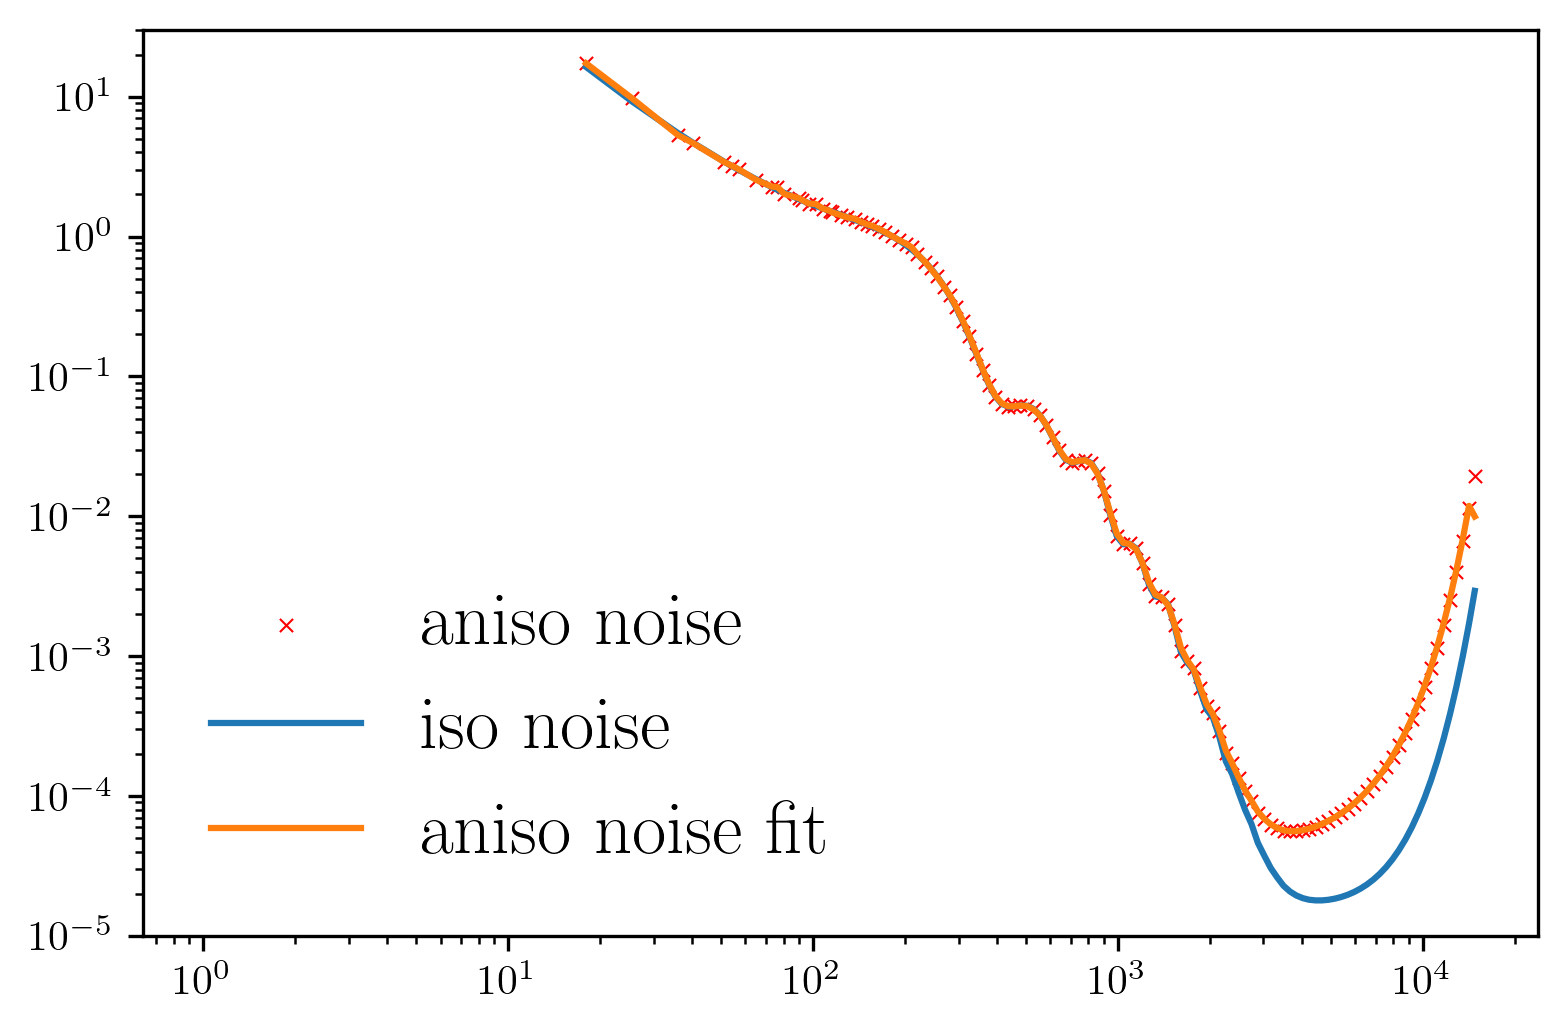

In [82]:

plt.figure(dpi=300)

# plt.errorbar(a,b, yerr=c, label='estimated ftot with aniso noise')
plt.scatter(a,b, label='aniso noise', marker='x', linewidth=0.5, color='red', s=10)


plt.plot(ftot_binned[0][idxs], ftot_binned[1][idxs], label='iso noise')


plt.plot(ftot_aniso_fit_binned[0][idxs], ftot_aniso_fit_binned[1][idxs], label='aniso noise fit')

plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-5, 3e1)

##SETS LIMS
plt.legend(frameon=False)

In [83]:
with open('f_aniso_ftot.pkl', 'wb') as f:
    pickle.dump(f_ansioNoise, f)